In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tabulate import tabulate

In [2]:
#loading train data set

with open('train_dataset.pickle','rb') as f:
    train_set = pickle.load(f)
    train = pd.DataFrame( train_set, columns = ['X','Y'])
    
#loading test data set

with open('test_dataset.pickle','rb') as g:
    test_set = pickle.load(g)
    test = pd.DataFrame(test_set, columns=['X', 'Y'])


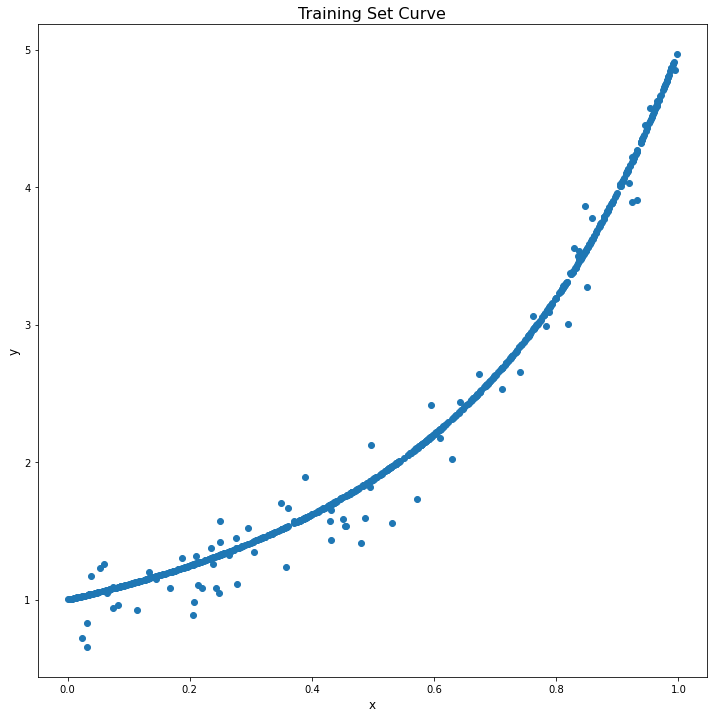

In [3]:
# Plotting the Training set

plt.figure(figsize=(12,12))
plt.scatter(train['X'], train['Y'])
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Training Set Curve', fontsize=16)
plt.show()

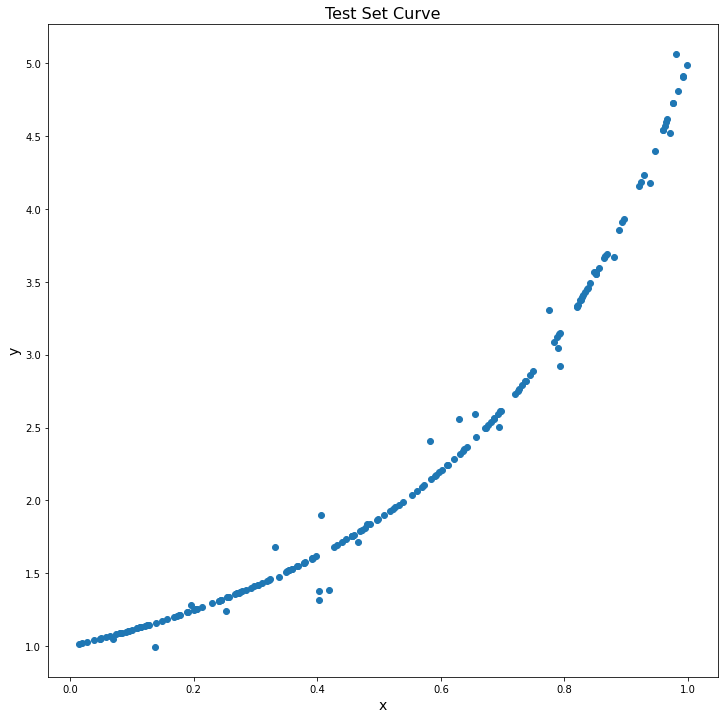

In [4]:
# Plotting the test set

plt.figure(figsize=(12,12))
plt.scatter(test['X'], test['Y'])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Test Set Curve', fontsize=16)
plt.show()

Train data is more compact since it has 800 values or points.
Test data is more scarce since it has 200 values or points.

In [5]:
partition_size = 20  #number of partitions

#np.random.shuffle(train)

train_split = np.array_split(train,partition_size)

print(len(train))           #total size
print(len(train_split))     #train_split now contains 20 partitions of data
print(len(train_split[0]))  #each sample in train_split has 800/20 = 40 data values

# print(train_split[0])     #just to see how dataset looks like now
# print(test)               #200 columns
# print(len(test))

800
20
40


In [6]:
trained_models = []   # empty list called models that will store the trained models 
                      #for each degree of polynomial fit.

# for every degree of polynomial fit

for deg in range(1,16):
    
    trained_cur_degree_model = []  #will store the trained models for the current degree of polynomial fit i.
      
    polynomialobj = PolynomialFeatures(degree=deg)  #Creates an instance of the PolynomialFeatures class 
                                                    #with the current degree of polynomial fit i.
        

    # for every training data subset
    
    for j in range(partition_size):
        
        sample = train_split[j]   #Extracts the jth training data subset from a list train_split of 20 subsets.
        
        train_x = sample['X']                       #extracting only X values out of sample 
        train_x = np.array(train_x).reshape(-1,1)   # making it into column vector using reshape
        
        transformed_train_x = polynomialobj.fit_transform(train_x)
        
        train_y = sample['Y']                    #extracting only Y values out of sample 
        train_y = np.array( train_y).reshape(-1,1)   #making it into column vector using reshape  
        
#         print(train_x)
#         print(train_y)
       
        linreg = LinearRegression(fit_intercept=False).fit(transformed_train_x,train_y)
        
        trained_cur_degree_model.append(linreg) 
    trained_models.append(trained_cur_degree_model)
#After the loop completes, models will be a 2D list of trained models, where each row corresponds to a degree of polynomial fit and each column corresponds to a training data subset.   

Calculating Bias, Variance and Mean Squared Error

In [7]:
test_x = np.array(test['X']).reshape(-1,1)
test_y = np.array(test['Y']).reshape(-1,1)

In [8]:
bias = []
bias_square = []
variance = []
mse = []
resultarray = []

for deg in range(15):
    
    total_sum = [0]*200
    total_var = [0]*200
    total_err = [0]*200
    
    polyobj = PolynomialFeatures(degree=deg+1)
    transformed_test_x = polyobj.fit_transform(test_x)
    
    cur_val = []
    
    total_sum = np.array(total_sum).reshape(-1,1)
    total_var = np.array(total_var).reshape(-1,1)
    total_err = np.array(total_err).reshape(-1,1)
    

    for j in range(20):
        
        cur_val.append(trained_models[deg][j].predict(transformed_test_x))
        
        total_sum = total_sum + cur_val[j]    # calculating sum to obtain mean of all predicted values in the end
        total_var = total_var + cur_val[j]**2 # calculating summation of squares
        total_err = total_err + (cur_val[j] - test_y)**2 #calculating error using least squares approach -
                                                         #summation of squares of difference between predicted values 
                                                         #and actual value
        
    # calculating expected values
    
    pred = total_sum / partition_size         # this gives mean predicted value for each degree
    var = total_var / partition_size - pred**2
    mse_val = total_err / partition_size
    bias_square_val = np.mean((pred - test_y)**2)
    bias_val = np.mean(np.abs(pred - test_y)) # this gives mean bias for each degree 
                                              # (since bias is a measure of error in data
                                              # we simply calculate absolute difference 7
                                              # between predicted value and given value for y)
    
   
    bias.append(bias_val)
    bias_square.append(bias_square_val)
    variance.append(np.mean(var))
    mse.append(np.mean(mse_val))
    resultarray.append(pred)
    
len(cur_val) # 20: for each partition

20

In [9]:
# Tabulating the Bias-Variance-MSE
from tabulate import tabulate
table_bias_variance_mse = {
    'Degree': [i for i in range(1, 16)],
    'Bias': bias,
    'Variance': variance,
    'MSE' : mse
}

print(tabulate(table_bias_variance_mse, headers='keys', tablefmt='psql'))

+----------+-----------+-------------+------------+
|   Degree |      Bias |    Variance |        MSE |
|----------+-----------+-------------+------------|
|        1 | 0.269398  | 0.00868095  | 0.123073   |
|        2 | 0.0862565 | 0.00122436  | 0.0133656  |
|        3 | 0.0332718 | 0.000337339 | 0.00504545 |
|        4 | 0.0242826 | 0.000366999 | 0.0046061  |
|        5 | 0.0238793 | 0.000461938 | 0.00465952 |
|        6 | 0.0239554 | 0.00058152  | 0.00477993 |
|        7 | 0.02483   | 0.000916796 | 0.00510317 |
|        8 | 0.0248874 | 0.00176092  | 0.00602264 |
|        9 | 0.0304184 | 0.00827683  | 0.0131353  |
|       10 | 0.0286639 | 0.00650085  | 0.0109153  |
|       11 | 0.0365903 | 0.0326928   | 0.0390896  |
|       12 | 0.0709172 | 0.884494    | 0.941428   |
|       13 | 0.0422491 | 0.054317    | 0.0618877  |
|       14 | 0.156428  | 8.04334     | 8.48912    |
|       15 | 0.08913   | 2.66963     | 2.74963    |
+----------+-----------+-------------+------------+


2.4 Irreducible Error Calculation

From the formula:

Mean Squared Error = Bias^2 + Variance + Irreducible Error, we do
Irreducible Error = Mean Squared Error - Bias^2 - Variance 

In [10]:
irreducible_error = np.array(mse) - np.array(bias_square) - np.array(variance)

table_irreducible_error = {
    'Degree': [deg for deg in range(1, 16)],
    'Irreducible Error' : irreducible_error
}

print(tabulate(table_irreducible_error, headers='keys', tablefmt='psql'))

+----------+---------------------+
|   Degree |   Irreducible Error |
|----------+---------------------|
|        1 |         1.97758e-16 |
|        2 |         1.30104e-17 |
|        3 |         4.6187e-16  |
|        4 |        -7.55147e-17 |
|        5 |        -4.68972e-16 |
|        6 |        -1.58185e-16 |
|        7 |         5.31259e-17 |
|        8 |         4.79217e-17 |
|        9 |        -8.1532e-17  |
|       10 |        -2.86229e-17 |
|       11 |        -4.16334e-17 |
|       12 |         0           |
|       13 |         1.17961e-16 |
|       14 |         1.77636e-15 |
|       15 |         4.44089e-16 |
+----------+---------------------+


Task 4 : Plotting Bias^2 − Variance Trade-off graph

(0.0, 0.14)

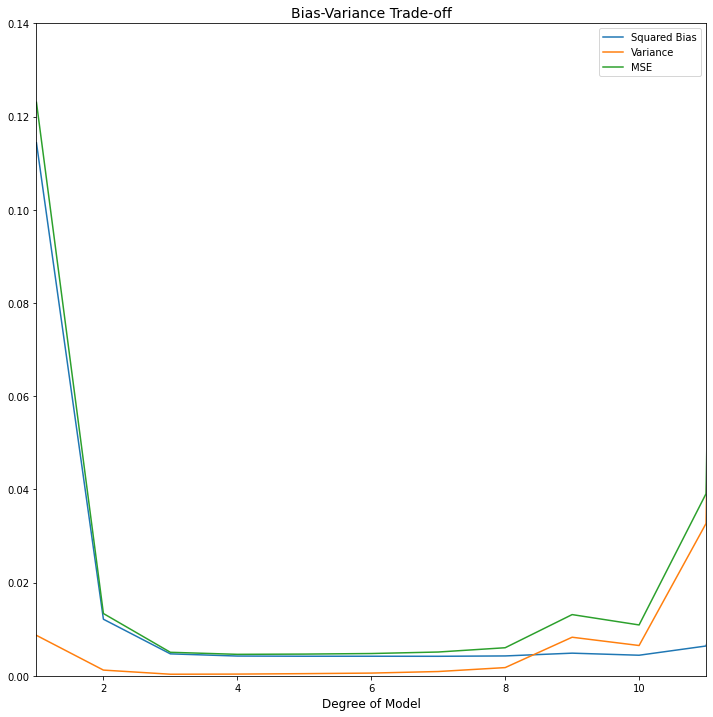

In [11]:
# depicting the bias-variance tradeoff
plt.figure(figsize=(12,12))
plt.plot(range(1,16), bias_square)
plt.plot(range(1,16), variance)
plt.plot(range(1,16), mse)
plt.xlabel('Degree of Model', fontsize=12)
plt.title('Bias-Variance Trade-off', fontsize=14)
plt.legend(['Squared Bias', 'Variance', 'MSE'])
plt.xlim(1,11)
plt.ylim(0,0.14)

(0.0, 0.14)

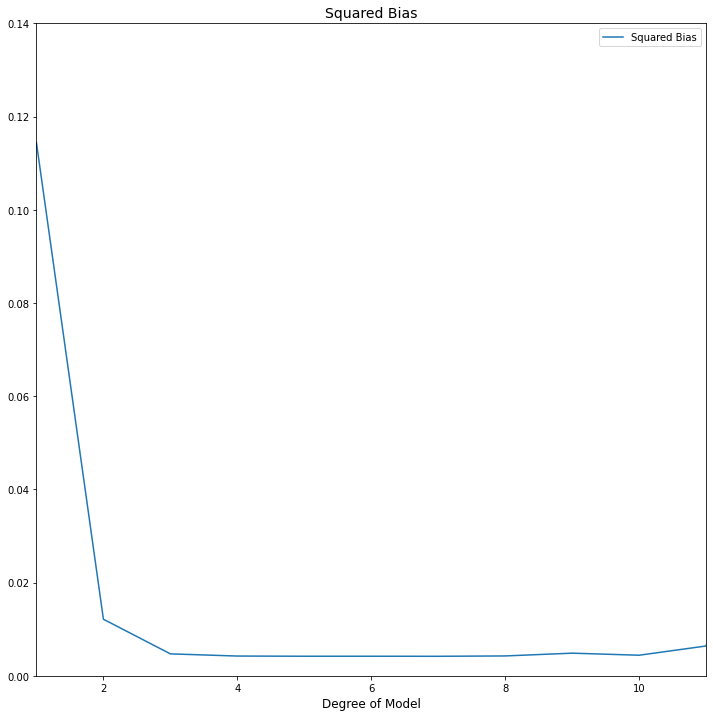

In [12]:
# depicting the bias
plt.figure(figsize=(12,12))
plt.plot(range(1,16), bias_square)
# plt.plot(range(1,16), variance)
# plt.plot(range(1,16), mse)
plt.xlabel('Degree of Model', fontsize=12)
plt.title('Squared Bias', fontsize=14)
plt.legend(['Squared Bias'])
plt.xlim(1,11)
plt.ylim(0,0.14)

(0.0, 0.14)

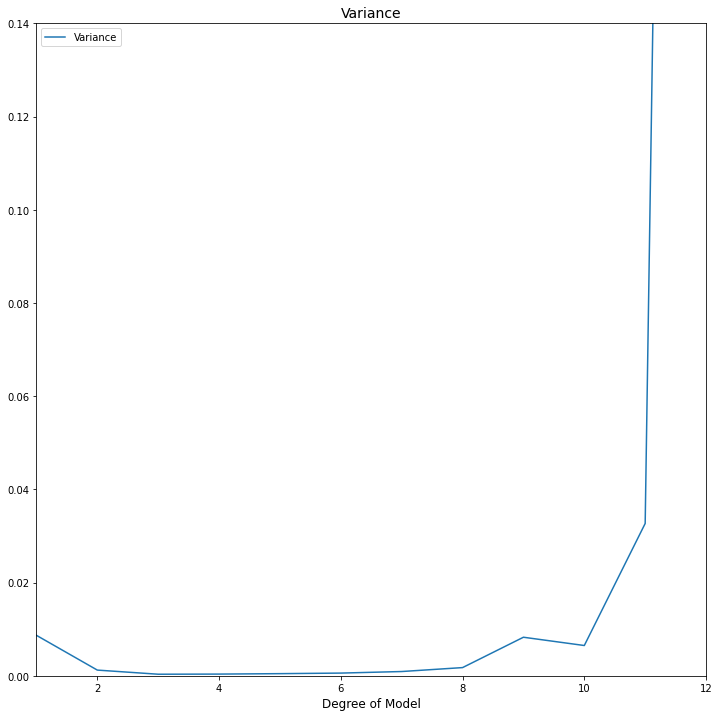

In [13]:
# depicting the variance
plt.figure(figsize=(12,12))
# plt.plot(range(1,16), bias_square)
plt.plot(range(1,16), variance)
plt.xlabel('Degree of Model', fontsize=12)
plt.title('Variance',fontsize=14)
plt.legend(['Variance'])
plt.xlim(1,12)
plt.ylim(0,0.14)